# Constructing Large Controlled Nots
[Part 1](https://algassert.com/circuits/2015/06/05/Constructing-Large-Controlled-Nots.html), [part 2](https://algassert.com/circuits/2015/06/12/Constructing-Large-Increment-Gates.html), [part 3](https://algassert.com/circuits/2015/06/22/Using-Quantum-Gates-instead-of-Ancilla-Bits.html) by Craig Gidney.

In [2]:
from qiskit import *
import numpy as np

## Part 1: $C^nNOT$ with 1 ancilla bit

**$C^nNOT$ with 1 borrowed bit**

The following construction decomposes a $C^nNOT$ gate into four gates: two $C^{\lceil \frac{n}{2} \rceil}NOT$s and two $C^{\lceil \frac{n + 1}{2} \rceil}NOT$s.

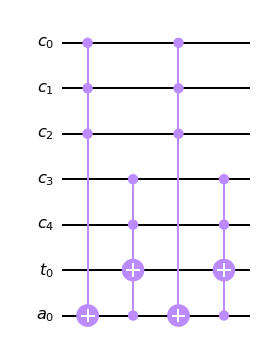

In [246]:
n = 5

control_reg = QuantumRegister(n, 'c')
target_reg  = QuantumRegister(1, 't')
ancilla_reg = QuantumRegister(1, 'a')
circuit     = QuantumCircuit(control_reg, target_reg, ancilla_reg)

circuit.mct(control_reg[:int(np.ceil(n/2))], ancilla_reg[0])
circuit.mct(control_reg[int(np.ceil(n/2)):] + ancilla_reg[:], target_reg[0])
circuit.mct(control_reg[:int(np.ceil(n/2))], ancilla_reg[0])
circuit.mct(control_reg[int(np.ceil(n/2)):] + ancilla_reg[:], target_reg[0])

circuit.draw('mpl')

**$C^nNOT$ with $n-2$ borrowed bits**

The following construction uses $n-2$ ancilla bits to decompose a $C^nNOT$ into $\mathcal{O}(n)$ Toffoli gates.

In [187]:
def n_m_2_ancilla(circuit, control_reg, target_reg, ancilla_reg):
    n = len(control_reg)
    
    # first mountain
    circuit.ccx(ancilla_reg[-1], control_reg[-1], target_reg[0])
    for i in range(n - 4, -1, -1):
        circuit.ccx(ancilla_reg[i], control_reg[i + 2], ancilla_reg[i + 1])
    circuit.ccx(control_reg[0], control_reg[1], ancilla_reg[0])
    for i in range(0, n - 3):
        circuit.ccx(ancilla_reg[i], control_reg[i + 2], ancilla_reg[i + 1])
    circuit.ccx(ancilla_reg[-1], control_reg[-1], target_reg[0])

    # second mountain, i.e., uncomputation
    for i in range(n - 4, -1, -1):
        circuit.ccx(ancilla_reg[i], control_reg[i + 2], ancilla_reg[i + 1])
    circuit.ccx(control_reg[0], control_reg[1], ancilla_reg[0])
    for i in range(0, n - 3):
        circuit.ccx(ancilla_reg[i], control_reg[i + 2], ancilla_reg[i + 1])

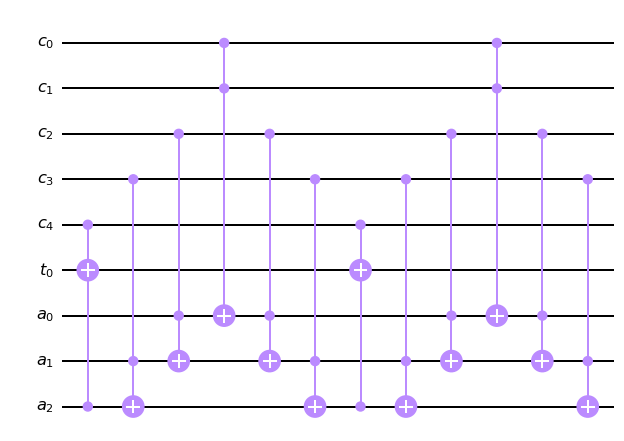

In [244]:
n = 5

control_reg = QuantumRegister(n, 'c')
target_reg  = QuantumRegister(1, 't')
ancilla_reg = QuantumRegister(n - 2, 'a')
circuit = QuantumCircuit(control_reg, target_reg, ancilla_reg)        

n_m_2_ancilla(circuit, control_reg, target_reg, ancilla_reg)

circuit.draw('mpl')

**Combining both techniques to get a Toffoli decomposition with 1 ancilla bit**

To combine the two techniques above, we first decompose the $C^nNOT$ gate into four smaller gates using only one qubit. Then, we decompose each of this four gates with the $n-2$ ancilla bits technique without introducing any more ancillae; we borrow some unused bits (in the correspoding step) as ancilla and turn them back to their initial state before carrying on.

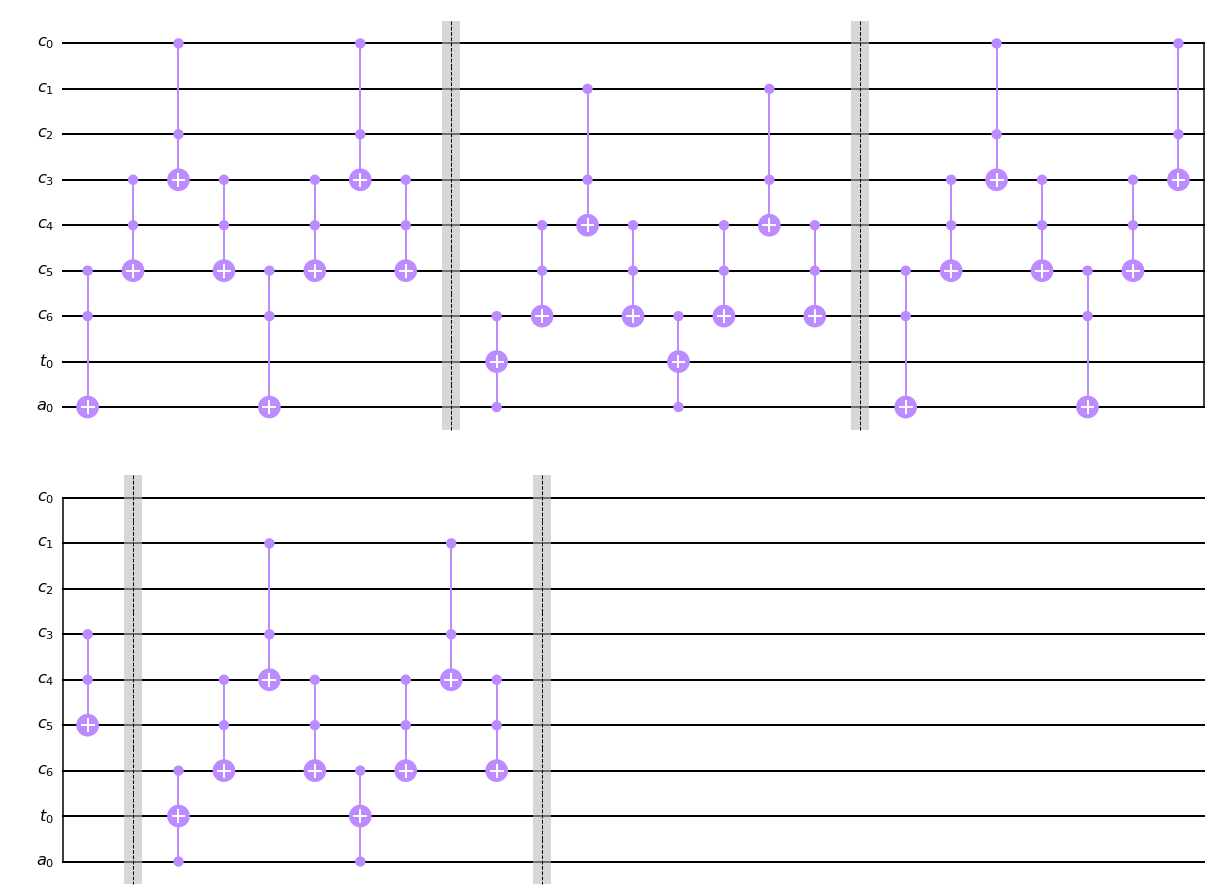

In [238]:
n = 7

control_reg = QuantumRegister(n, 'c')
target_reg  = QuantumRegister(1, 't')
ancilla_reg = QuantumRegister(1, 'a')
circuit     = QuantumCircuit(control_reg, target_reg, ancilla_reg)

for _ in range(2):
    # first gate
    controls = [i for i in range(n) if i % 2 == 0]
    target   = [-1]
    ancilla  = [i for i in range(n) if i not in controls]
    while len(ancilla) != len(controls) - 2:
        ancilla.pop(0)
    n_m_2_ancilla(circuit, controls, target, ancilla)

    circuit.barrier()

    # second gate
    controls = [i for i in range(n) if i % 2 == 1] + [n + 1]
    target   = [-2]
    ancilla  = [i for i in range(n) if i not in controls]
    while len(ancilla) != len(controls) - 2:
        ancilla.pop(0)
    n_m_2_ancilla(circuit, controls, target, ancilla)

    circuit.barrier()

circuit.draw('mpl')